In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from skfeature.function.similarity_based.lap_score import lap_score, feature_ranking
from sklearn.metrics import pairwise_distances
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid')

<br>

In [2]:
texturas = pd.read_excel('BBDD_caEnd_articulo_jmCarot.xlsx', usecols='DG:FKW')
grado = pd.read_excel('BBDD_caEnd_articulo_jmCarot.xlsx', usecols='AT')

na_ind = [47, 91, 94, 97]
texturas = texturas.drop(na_ind)
grado = grado.drop(na_ind)

grado_dico = grado.replace({1:0, 2:1, 3:1})

In [3]:
X_texturas = texturas.values
scaler = StandardScaler()
X_texturas_scaled = scaler.fit_transform(X_texturas)
Y = grado_dico.values.T[0] 

<br>

### Laplacian Feature Selection

The smaller the laplacian score is, the more important the feature is

In [5]:
def compute_W(X, Y, eps):
    # Simple kernel
    n = X.shape[0]
    dist_matrix = pairwise_distances(X)
    nn_matrix = np.array([ [index for index, d in enumerate(dist_matrix[i,:]) if d < eps and index != i and Y[index] == Y[i]] for i in range(n) ])
    # Weight matrix
    W = []
    for i in range(n):
        w_aux = np.zeros((1, n))
        similarities = np.array([ 1 for v in nn_matrix[i]] )
        np.put(w_aux, nn_matrix[i], similarities)
        W.append(w_aux[0])
    W = np.array(W)
    return W

In [6]:
eps = 5000
W = compute_W(X_texturas_scaled, Y, eps)

In [7]:
W

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.]])

In [8]:
L = lap_score(X_texturas_scaled, W = sparse.csr_matrix(W))
f = feature_ranking(L)
f

array([ 361,  353,  539, ..., 3995, 1442, 2293], dtype=int64)

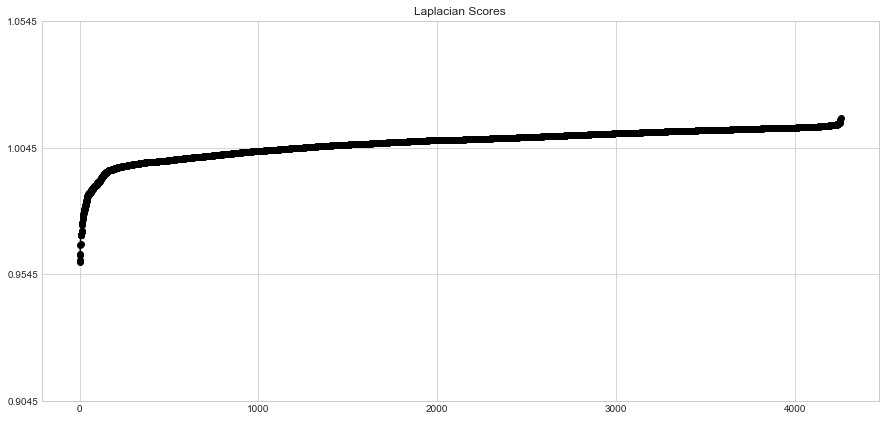

In [9]:
fig = plt.figure(figsize=(15,7))
plt.plot(list(range(len(f))), L[f], '-ok')
plt.grid(True)
plt.yticks(np.arange(min(L)-0.055, max(L)+0.05, step=0.05))
plt.title('Laplacian Scores')
plt.show()

<br>

## Cross-validation Laplacian Score
### SVM kernel = linear

In [10]:
print(len(f[L[f] < [L[f][0] + (i * 0.0001) for i in range(1, 358)][-1]]))

158


In [11]:
modelos = [('linear', 1, 0, 'scale')] 

# (kernel, C, degree, gamma)
hiperparam = {c:None for c in modelos}
for (kernel, C, d, g),_ in hiperparam.items():
    results = {}
    laplacian_thresholds = [L[f][0] + (i * 0.0001) for i in range(1, 358)]
    for i in laplacian_thresholds:
        X_texturas_selected = X_texturas_scaled[:,f[L[f] < i]] # Variables con un valor de Laplacian Score menor que el threshold

        kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 344)
        probas = np.zeros((X_texturas_selected.shape[0],2))
        for train_index, test_index in kf.split(X_texturas_selected, Y):
            X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            dt = SVC(probability = True, kernel = kernel, C = C, degree = d, gamma = g, random_state = 3)
            probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
            probas[test_index, :] = probas_

        fpr, tpr, thresholds = roc_curve(Y, probas[:, 1])
        roc_auc = auc(fpr, tpr)
        results[i] = roc_auc
    hiperparam[(kernel, C, d, g)] = results

In [12]:
{m: max([(v, c) for c, v in results.items()]) for m, results in hiperparam.items()}

{('linear', 1, 0, 'scale'): (0.7589840283939664, 0.992679181227688)}

In [15]:
dic_results = {
 ('linear', 1, 0, 'scale'): (0.766304347826087, 0.992579181227688),
 ('rbf', 1, 0, 'scale'): (0.6912156166814551, 0.987379181227688),
 ('sigmoid', 1, 0, 'scale'): (0.6154614019520852, 0.970379181227688),
 ('poly', 1, 2, 'scale'): (0.62877107364685, 0.980279181227688),
 ('linear', 100, 0, 'scale'): (0.7272626441881102, 0.9951791812276879),
 ('rbf', 100, 0, 'scale'): (0.6553904170363798, 0.9806791812276879),
 ('sigmoid', 100, 0, 'scale'): (0.6622670807453416, 0.9698791812276879),
 ('poly', 100, 2, 'scale'): (0.5824090505767524, 0.9614791812276879),
 ('linear', 0.01, 0, 'scale'): (0.6913265306122449, 0.9951791812276879),
 ('rbf', 0.01, 0, 'scale'): (0.6899955634427684, 0.9869791812276879),
 ('sigmoid', 0.01, 0, 'scale'): (0.6070319432120674, 0.971079181227688),
 ('poly', 0.01, 2, 'scale'): (0.6061446317657498, 0.986579181227688),
 ('linear', 0.02, 0, 'auto'): (0.7051907719609583, 0.992679181227688),
 ('linear', 0.3, 0, 'auto'): (0.737910381543922, 0.9929791812276879),
 ('linear', 0.4, 0, 'auto'): (0.7372448979591837, 0.9930791812276879),
 ('linear', 0.5, 0, 100): (0.7322537710736468, 0.992279181227688),
 ('linear', 0.7, 0, 100): (0.7494454303460515, 0.9929791812276879),
 ('linear', 0.9, 0, 100): (0.7600931677018633, 0.992379181227688),
 ('poly', 0.02, 2, 'auto'): (0.6103593611357587, 0.976179181227688),
 ('poly', 0.3, 2, 'auto'): (0.6316548358473825, 0.9708791812276879),
 ('poly', 0.4, 2, 'auto'): (0.6338731144631765, 0.971279181227688),
 ('poly', 0.5, 2, 'auto'): (0.6363132209405501, 0.971079181227688),
 ('poly', 0.7, 2, 'auto'): (0.6356477373558119, 0.970379181227688),
 ('poly', 0.9, 2, 'auto'): (0.6207852706299911, 0.982279181227688),
 ('rbf', 0.02, 0, 'auto'): (0.6966503992901508, 0.9869791812276879),
 ('rbf', 0.3, 0, 'auto'): (0.6888864241348713, 0.980479181227688),
 ('rbf', 0.4, 0, 'auto'): (0.6970940550133097, 0.9870791812276879),
 ('rbf', 0.5, 0, 100): (0.6121339840283939, 0.960379181227688),
 ('rbf', 0.7, 0, 100): (0.5870674356699201, 0.961279181227688),
 ('rbf', 0.9, 0, 100): (0.6143522626441881, 0.9615791812276879),
 ('sigmoid', 0.02, 0, 'auto'): (0.6187888198757764, 0.9716791812276879),
 ('sigmoid', 0.3, 0, 'auto'): (0.6101375332741792, 0.971479181227688),
 ('sigmoid', 0.4, 0, 'auto'): (0.6143522626441881, 0.970479181227688),
 ('sigmoid', 0.5, 0, 100): (0.6558340727595385, 0.9708791812276879),
 ('sigmoid', 0.7, 0, 100): (0.6603815439219165, 0.989379181227688),
 ('sigmoid', 0.9, 0, 100): (0.642746228926353, 0.9707791812276879),
 ('linear', 2, 0, 'auto'): (0.748114463176575, 0.9921791812276879),
 ('rbf', 1, 0, 'auto'): (0.7059671694764862, 0.9869791812276879),
 ('sigmoid', 1, 0, 'auto'): (0.6218944099378881, 0.9709791812276879),
 ('poly', 1, 2, 'auto'): (0.6396406388642413, 0.9698791812276879),
 ('linear', 4, 0, 'auto'): (0.7199423247559894, 0.9929791812276879),
 ('rbf', 100, 0, 'auto'): (0.6580523513753327, 0.991479181227688),
 ('sigmoid', 100, 0, 'auto'): (0.6596051464063887, 0.971079181227688),
 ('poly', 100, 2, 'auto'): (0.604148181011535, 0.966479181227688),
 ('linear', 5, 0, 'auto'): (0.7201641526175687, 0.9951791812276879),
 ('rbf', 0.01, 0, 'auto'): (0.6959849157054125, 0.987379181227688),
 ('sigmoid', 0.01, 0, 'auto'): (0.6150177462289264, 0.9715791812276879),
 ('poly', 0.01, 2, 'auto'): (0.6210070984915705, 0.977179181227688),
 ('linear', 7, 0, 100): (0.7029724933451642, 0.9950791812276879),
 ('rbf', 1, 0, 100): (0.580634427684117, 0.9616791812276879),
 ('sigmoid', 1, 0, 100): (0.6491792369121562, 0.9705791812276879),
 ('linear', 8, 0, 100): (0.6990905057675245, 0.9890791812276879),
 ('rbf', 100, 0, 100): (0.5475820763087844, 0.9619791812276879),
 ('sigmoid', 100, 0, 100): (0.6301020408163265, 0.971079181227688),
 ('linear', 10, 0, 100): (0.7290372670807453, 0.9951791812276879),
 ('rbf', 0.01, 0, 100): (0.5927240461401952, 0.962379181227688),
 ('sigmoid', 0.01, 0, 100): (0.6713620230700976, 0.9757791812276879)}

{k: v for k, v in sorted(dic_results.items(), key=lambda item: item[1], reverse = True)}

{('linear', 1, 0, 'scale'): (0.766304347826087, 0.992579181227688),
 ('linear', 0.9, 0, 100): (0.7600931677018633, 0.992379181227688),
 ('linear', 0.7, 0, 100): (0.7494454303460515, 0.9929791812276879),
 ('linear', 2, 0, 'auto'): (0.748114463176575, 0.9921791812276879),
 ('linear', 0.3, 0, 'auto'): (0.737910381543922, 0.9929791812276879),
 ('linear', 0.4, 0, 'auto'): (0.7372448979591837, 0.9930791812276879),
 ('linear', 0.5, 0, 100): (0.7322537710736468, 0.992279181227688),
 ('linear', 10, 0, 100): (0.7290372670807453, 0.9951791812276879),
 ('linear', 100, 0, 'scale'): (0.7272626441881102, 0.9951791812276879),
 ('linear', 5, 0, 'auto'): (0.7201641526175687, 0.9951791812276879),
 ('linear', 4, 0, 'auto'): (0.7199423247559894, 0.9929791812276879),
 ('rbf', 1, 0, 'auto'): (0.7059671694764862, 0.9869791812276879),
 ('linear', 0.02, 0, 'auto'): (0.7051907719609583, 0.992679181227688),
 ('linear', 7, 0, 100): (0.7029724933451642, 0.9950791812276879),
 ('linear', 8, 0, 100): (0.69909050576752

In [13]:
results_best_model = hiperparam[('linear', 1, 0, 'scale')]

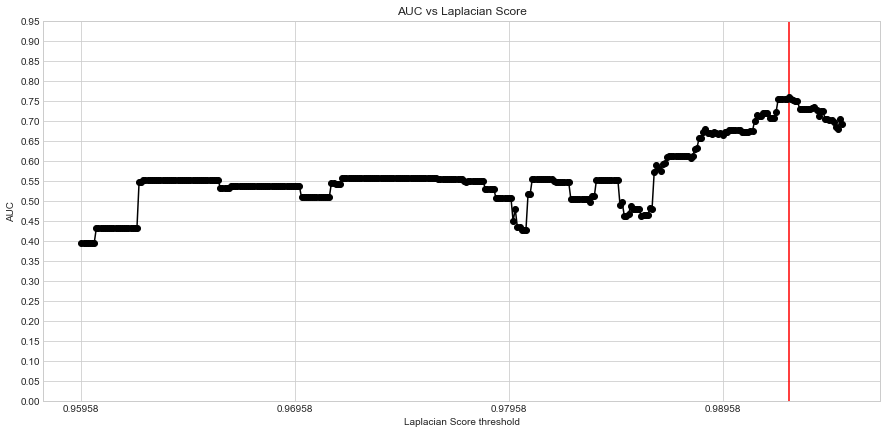

In [14]:
fig = plt.figure(figsize=(15,7))
plt.axvline(x = max([(v, c) for c, v in results_best_model.items()])[1], color = 'r')
plt.plot(results_best_model.keys(), results_best_model.values(), '-ok')
plt.grid(True)
plt.yticks(np.arange(0, 1, step=0.05))
plt.xticks(np.arange(min(laplacian_thresholds), max(laplacian_thresholds), step = 0.01))
plt.title('AUC vs Laplacian Score')
plt.xlabel('Laplacian Score threshold')
plt.ylabel('AUC')
plt.show()

In [15]:
X_texturas_selected = X_texturas_scaled[:,f[L[f] < 0.992679181227688]] 
    
kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 344)
probas = np.zeros((X_texturas_selected.shape[0],2))
for train_index, test_index in kf.split(X_texturas_selected, Y):
    X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    dt = SVC(probability = True, kernel = 'linear', C = 1, random_state = 3)
    probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
    probas[test_index, :] = probas_

In [16]:
probs_df = pd.DataFrame(probas)
probs_df['Y'] = Y
probs_df.to_excel('Predictions_Laplacian_Score_SVM.xlsx')